# Image classification via fine-tuning with EfficientNet

**Author:** [Yixing Fu](https://github.com/yixingfu)<br>
**Date created:** 2020/06/30<br>
**Last modified:** 2020/07/16<br>
**Description:** Use EfficientNet with weights pre-trained on imagenet for Stanford Dogs classification.

# Experiment with Bilinear CNN
Bilinear CNN paper: http://vis-www.cs.umass.edu/bcnn/
With code from: https://github.com/NiFangBaAGe/FBCNN/blob/master/load_model.py

Self-connected Bilinear like Breast Cancer paper
https://www.frontiersin.org/articles/10.3389/fgene.2020.547327/full

Use colorectal images, 625 x 10 labels. Good textural data like the breast cancer data.
https://www.tensorflow.org/datasets/catalog/colorectal_histology

In [ ]:
# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()


Not connected to a TPU runtime. Using CPU/GPU strategy
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [ ]:
import tensorflow_datasets as tfds

batch_size = 64

dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete1VJ1MT/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete1VJ1MT/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


When the dataset include images with various size, we need to resize them into a
shared size. The Stanford Dogs dataset includes only images at least 200x200
pixels in size. Here we resize the images to the input size needed for EfficientNet.

In [ ]:
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

### Visualizing the data

The following code shows the first 9 images with their labels.

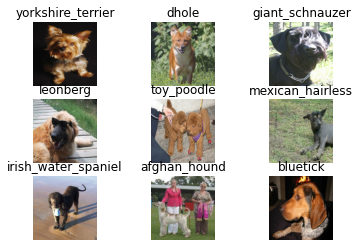

In [ ]:
import matplotlib.pyplot as plt


def format_label(label):
    string_label = label_info.int2str(label)
    return string_label.split("-")[1]


label_info = ds_info.features["label"]
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")


### Data augmentation

We can use the preprocessing layers APIs for image augmentation.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

This `Sequential` model object can be used both as a part of
the model we later build, and as a function to preprocess
data before feeding into the model. Using them as function makes
it easy to visualize the augmented images. Here we plot 9 examples
of augmentation result of a given figure.

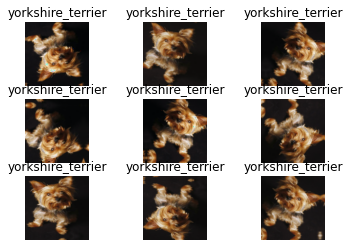

In [ ]:
for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(tf.expand_dims(image, axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title("{}".format(format_label(label)))
        plt.axis("off")


### Prepare inputs

Once we verify the input data and augmentation are working correctly,
we prepare dataset for training. The input data are resized to uniform
`IMG_SIZE`. The labels are put into one-hot
(a.k.a. categorical) encoding. The dataset is batched.

Note: `prefetch` and `AUTOTUNE` may in some situation improve
performance, but depends on environment and the specific dataset used.
See this [guide](https://www.tensorflow.org/guide/data_performance)
for more information on data pipeline performance.

In [ ]:
# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(
    input_preprocess, num_parallel_calls=tf.data.AUTOTUNE
)
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess)
ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)


A little code for plotting the results.

In [ ]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


# plot_hist(hist)

# Bilinear CNN
This layer creates a matrix where the columns are the channel values for all feature maps, and the rows are height X width of the feature maps. It then creates the 'outer product' of the matrix multiplied against itself.

In [ ]:
!pip install -q git+https://github.com/LanceNorskog/keras-fbcnn.git
from keras_fbcnn import BilinearCNN2D

## Transfer learning from pre-trained weights

Here we initialize the model with pre-trained ImageNet weights,
and we fine-tune it on our own dataset.

In [ ]:

def build_model(num_classes, bilinear=False):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    eff = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")
    # Freeze the pretrained weights
    eff.trainable = False
    sub_model = tf.keras.Model(inputs, eff.output, name='effb0')
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    sub_layer = sub_model(inputs)

    # Build either bilinear or classic global-average-pooling top
    if bilinear:
        x = BilinearCNN2D()([sub_layer, sub_layer])
    else:
        x = layers.GlobalAveragePooling2D(name="avg_pool")(sub_layer)
        x = layers.BatchNormalization()(x)
        top_dropout_rate = 0.2
        x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return eff, model


For the sake of benchmarking, we will create a model, compile the tensor graph, and throw it away- just to warm up the tensor compiler.

In [ ]:
import time
with strategy.scope():
    block_model, model = build_model(num_classes=NUM_CLASSES)
    prediction = model.predict(np.zeros((1,IMG_SIZE,IMG_SIZE,3)))
    t1 = time.perf_counter()
    prediction = model.predict(np.zeros((128, IMG_SIZE, IMG_SIZE, 3)))
    t2 = time.perf_counter()
    print('(original) time taken to run:',t2-t1)
    print('(original) time taken per image:', (t2-t1)/128)
    block_model, model = build_model(num_classes=NUM_CLASSES, bilinear=True)
    prediction = model.predict(np.zeros((1,IMG_SIZE,IMG_SIZE,3)))
    t1 = time.perf_counter()
    prediction = model.predict(np.zeros((128, IMG_SIZE, IMG_SIZE, 3)))
    t2 = time.perf_counter()
    print('(bilinear) time taken to run:',t2-t1)
    print('(bilinear) time taken per image:', (t2-t1)/128)



INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


16719872/16705208 [==============================] - 0s 0us/step
(original) time taken to run: 3.0801035640000123
(original) time taken per image: 0.024063309093750096
(bilinear) time taken to run: 3.201147754000033
(bilinear) time taken per image: 0.025008966828125256


First, train a standard classification top.

In [ ]:
with strategy.scope():
    block_model, model = build_model(num_classes=NUM_CLASSES)

epochs = 80  # @param {type: "slider", min:2, max:80}
model.summary()
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, 
                callbacks=[early_stopping], verbose=2)
plot_hist(hist)

Model: "EfficientNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
effb0 (Functional)           (None, 7, 7, 1280)        4049571   
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 1280)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1280)              5120      
_________________________________________________________________
top_dropout (Dropout)        (None, 1280)              0         
_________________________________________________________________
pred (Dense)                 (None, 120)               153720    
Total params: 4,208,411
Trainable params: 156,280
Non-trainable params: 4,052,131
______________________________________

KeyboardInterrupt: ignored

Next, train a Bilinear top.

In [ ]:
with strategy.scope():
    block_model, model = build_model(num_classes=NUM_CLASSES, bilinear=True)

epochs = 80  # @param {type: "slider", min:2, max:80}
model.summary()
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, 
                callbacks=[early_stopping], verbose=2)
plot_hist(hist)